# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import multiprocessing
import numpy as np

import torch.utils.data as data

from lightning import Trainer
from torch import nn
from torch import optim

from src.util.image import (
    scale_image,
    reduce_depth_with_autoencoder,
    reduce_depth_with_patched_autoencoder,
    reduce_depth_with_pca,
)
from src.util.patches import extract_patches
from src.util.torch_device import resolve_torch_device
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.model.fully_convolutional_lenet import FullyConvolutionalLeNet
from src.visualization.plot import plot_segmentation_comparison, plot_epoch_generic
from src.data.dataset_decorator import UnlabeledDatasetDecorator
from src.model.autoencoder import SpatialAutoEncoder, SymmetricPointWiseAutoEncoder
from src.trainer.autoencoder_trainer import AutoEncoderTrainer
from src.loss.patch_loss import PatchLoss
from src.trainer.co_trainer import BiCoTrainer
from src.model.ensemble import Ensemble
from src.trainer.base_trainer import AdamOptimizedModule
from src.trainer.classification_trainer import ClassificationTrainer
from src.util.semi_guided import mask_patched_fraction, mask_patched

2. Prepare env

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

batch_size = 56
patch_size = 9
num_epochs = 12
learning_rate = 1e-3
fraction_of_examples = 0.1
examples_per_class = 30

device = resolve_torch_device()

generator = torch.Generator()
generator.manual_seed(random_seed)

In [3]:
f"Device is {device}"

'Device is mps'

3. Load dataset

In [4]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

_, x = scale_image(image)

In [5]:
num_classes = len(np.unique(labels))

f"Number of classes {num_classes}"

'Number of classes 17'

4. Reduce dimensions

In [6]:
reduced_dim_size = 200

In [7]:
# _, x = reduce_depth_with_pca(x, n_components=reduced_dim_size)

In [8]:
# auto_encoder_epochs = 100

# autoencoder = SymmetricPointWiseAutoEncoder([image_c, reduced_dim_size]).to(device)

# criterion = nn.MSELoss().to(device)
# optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
# trainer = AutoEncoderTrainer(
#     criterion,
#     auto_encoder_epochs,
#     optimizer,
# )

# x = reduce_depth_with_autoencoder(x, autoencoder, trainer, device)

In [9]:
# auto_encoder_epochs = 100

# autoencoder = SpatialAutoEncoder(
#     input_channels=image_c, embedding_size=reduced_dim_size
# ).to(device)

# trainer = AutoEncoderTrainer(
#     nn.MSELoss(),
#     auto_encoder_epochs,
#     optim.Adam(autoencoder.parameters(), lr=1e-3),
# )

# x = reduce_depth_with_patched_autoencoder(x, patch_size, autoencoder, [trainer], device)

5. Prepare dataset

In [10]:
x, y = extract_patches(x, labels, patch_size=patch_size)

# full_ds, labeled_ds, unlabeled_ds, y_masked = mask_patched_fraction(
#     x, y, fraction_of_examples, device
# )

full_ds, labeled_ds, unlabeled_ds, y_masked = mask_patched(
    x, y, examples_per_class, device
)

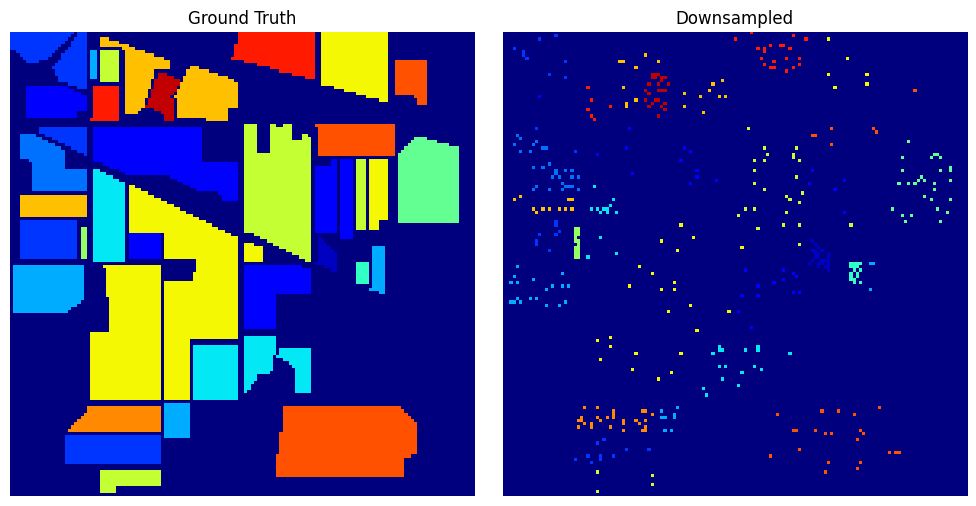

In [11]:
plot_segmentation_comparison(labels, y_masked.reshape(labels.shape), title2="Downsampled")

In [12]:
train_loader = data.DataLoader(
    labeled_ds,
    batch_size=batch_size,
    shuffle=True,
    generator=generator,
)
test_loader = data.DataLoader(
    full_ds,
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_ds),
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)

In [13]:
f"Training samples: {len(labeled_ds)}, Testing samples: {len(full_ds)}"

'Training samples: 464, Testing samples: 21025'

4. Train model

In [14]:
model = AdamOptimizedModule(
    FullyConvolutionalLeNet(reduced_dim_size, num_classes),
    lr=learning_rate,
).to(device)

# class_counts = np.bincount(y.flatten())
# total_pixels = class_counts.sum()
# num_classes = len(class_counts)
# weights = total_pixels / (num_classes * class_counts)
# weights = weights / weights.sum()
# weights_tensor = torch.tensor(weights, dtype=torch.float32, device=device)

# loss = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)
loss = nn.CrossEntropyLoss()

trainer = ClassificationTrainer(num_epochs, num_classes, loss, device)

In [15]:
feedback = trainer.fit(model, train_loader, test_loader)

  0%|          | 0/12 [00:00<?, ?it/s]

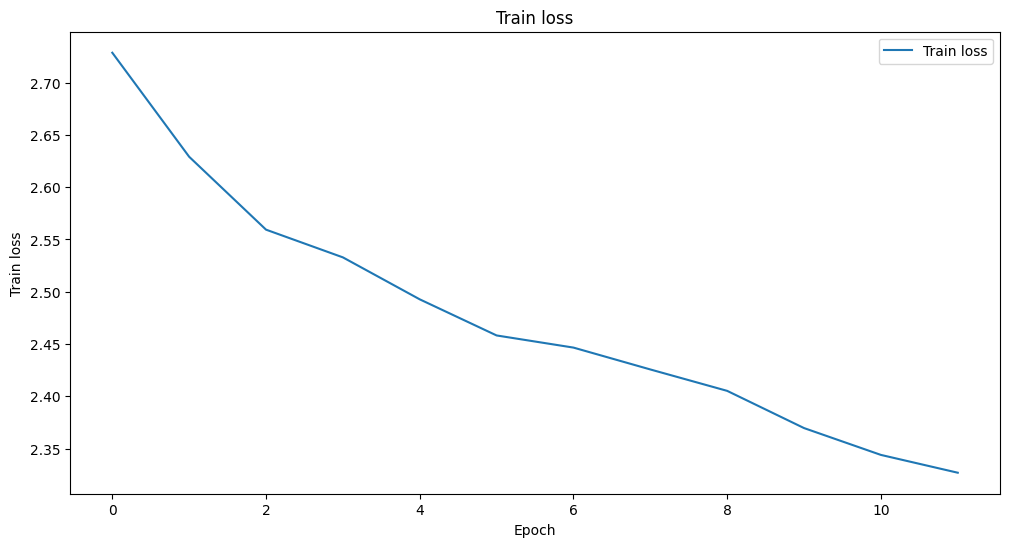

In [16]:
plot_epoch_generic(
    [it.train["train_loss"] for it in feedback.history],
    desc="Train loss",
)

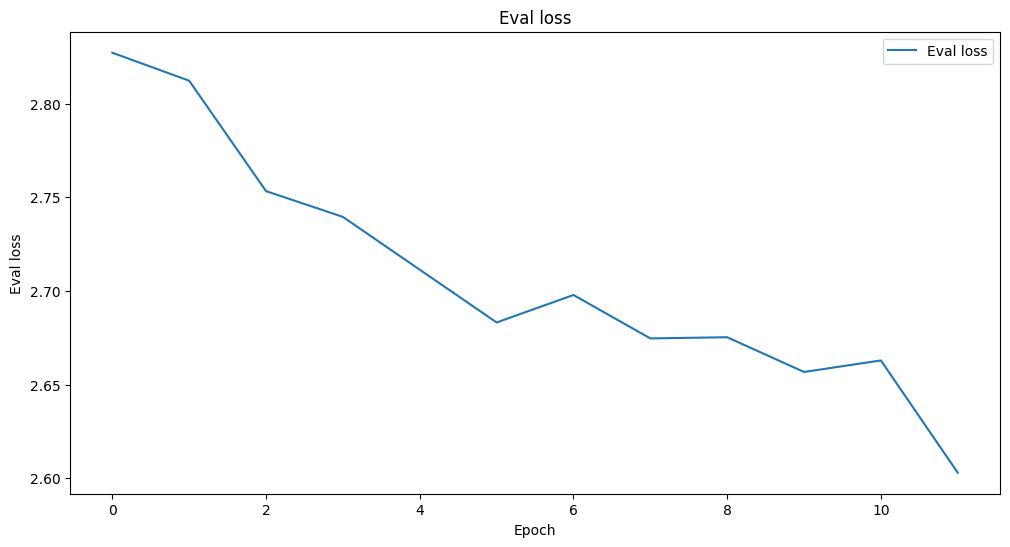

In [17]:
plot_epoch_generic(
    [it.eval["eval_loss"] for it in feedback.history],
    desc="Eval loss",
)

5. Display prediction

In [18]:
trainer.validate(model, test_loader)

{'eval_f1': 0.5046118497848511,
 'eval_accuracy_overall': 0.7790988683700562,
 'eval_accuracy_avg': 0.4905588626861572,
 'eval_kappa': 0.4172426462173462,
 'eval_loss': 2.602994680404663}

In [19]:
_, y_pred = trainer.predict(model, predict_loader)

In [20]:
y_pred = torch.cat(y_pred, dim=0)

In [21]:
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

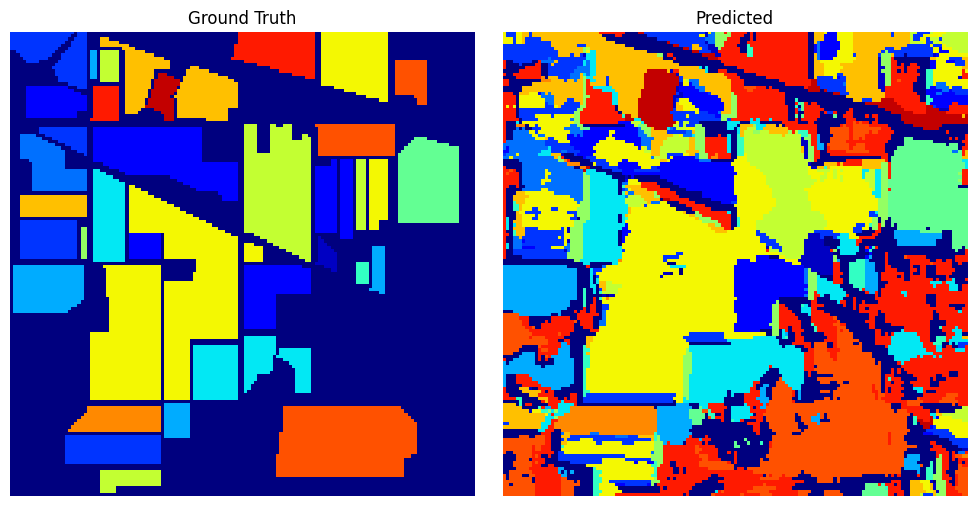

In [22]:
plot_segmentation_comparison(labels, y_pred.cpu().numpy())

6. Train semi-supervised model

In [23]:
x_tensor = torch.tensor(x, dtype=torch.float32, device=device).permute(0, 3, 1, 2)

In [24]:
model_1 = AdamOptimizedModule(
    FullyConvolutionalLeNet(reduced_dim_size, num_classes),
    lr=1e-3,
).to(device)

model_2 = AdamOptimizedModule(
    FullyConvolutionalLeNet(reduced_dim_size, num_classes),
    lr=1e-3,
).to(device)

co_trainer = BiCoTrainer(
    batch_size=58,
    confidence_threshold=0.9,
    generator=generator,
    trainer=ClassificationTrainer(
        num_epochs=12,
        num_classes=num_classes,
        criterion=loss,
        device=device,
        record_history=False,
    ),
)

In [25]:
feedback = co_trainer.fit(
    models=(model_1, model_2),
    labeled=labeled_ds,
    unlabeled=unlabeled_ds,
    eval_dl=test_loader,
)

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [26]:
feedback.history[-1].eval

{'eval_f1': 0.05103616416454315,
 'eval_accuracy_overall': 0.2717336416244507,
 'eval_accuracy_avg': 0.12275861948728561,
 'eval_kappa': 0.08537381887435913,
 'eval_loss': 2.8314948081970215}

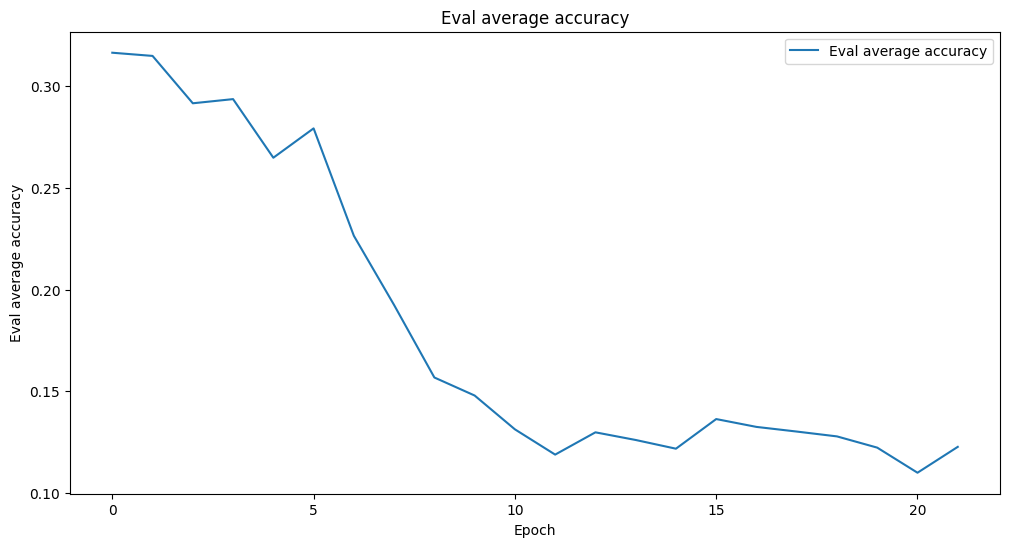

In [27]:
plot_epoch_generic(
    [it.eval["eval_accuracy_avg"] for it in feedback.history], desc="Eval average accuracy"
)

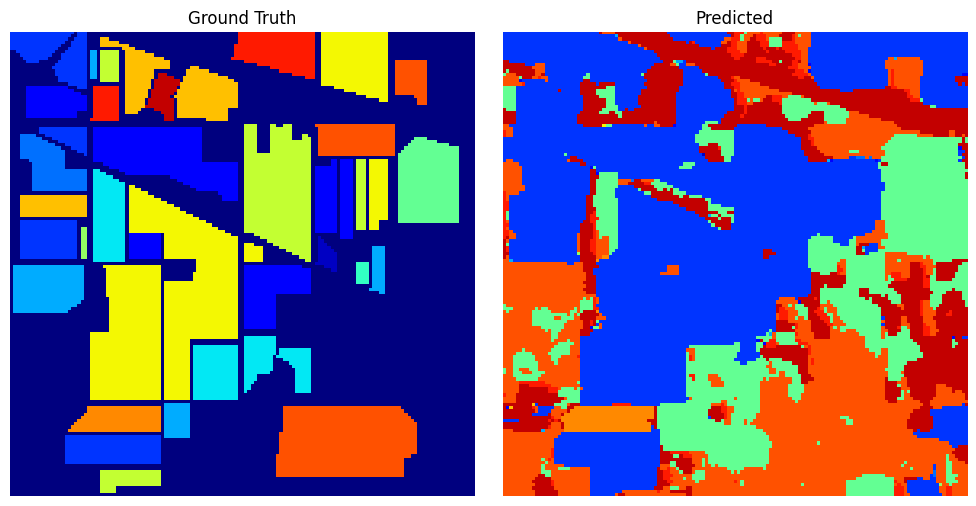

In [28]:
co_trained = Ensemble([model_1, model_2]).to(device)

y_pred = co_trained(x_tensor)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

plot_segmentation_comparison(labels, y_pred.cpu().numpy())